<a href="https://colab.research.google.com/github/DoubleCyclone/transfer-learning-dog-breeds/blob/main/notebooks/Transfer_Learning_for_Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will be working on a project about **Transfer Learning**. What is **Transfer Learning** you may ask. It is a strategy that can be used to adapt a model to a different than original task without fully retraining it. In our example, I will use a model called **ImageNet** which already has been trained on a dataset that includes 118 dog breeds and "transfer" its knowledge for usage on **Stanford Dogs** dataset which has 120 dog breeds instead. <br>
Now you may be curious about how this works. Basically, as the model has already been trained on similar data, it knows how to spot very simple patterns like edges and lines as well as complex ones like a whole dog or a vehicle. As you can guess, knowledge about some of these patterns do carry over to the new task. Though this does not mean a perfect accuracy or even the same accuracy as the original model is guaranteed, we can train an incredibly small fragment of the model with the new class labels so that it works well enough for the new task.
# 1 - Initial Setup
First of all, we need to import the required packages and download the **Stanford Dogs** dataset.

In [67]:
# Import packages
import kagglehub
from torchvision.datasets import ImageFolder
import os
from PIL import Image
from torchvision.transforms import transforms
from collections import Counter
import matplotlib.pyplot as plt
import random

In [51]:
# Download latest version
dataset_path = kagglehub.dataset_download("jessicali9530/stanford-dogs-dataset")

# Transformation and ImageFolder
data_transformation = transforms.Compose([
    transforms.Resize((200,200)), # Resize to 200x200 (depends on the will-be-used model)
    transforms.ToTensor() # Convert into Tensors
])
image_data_path = os.path.join(dataset_path, 'images', 'Images')
X_full = ImageFolder(root=image_data_path, transform=data_transformation)
print(f"Sample count : {len(X_full.imgs)}")
print(f"Class count : {len(X_full.classes)}")

Using Colab cache for faster access to the 'stanford-dogs-dataset' dataset.
Sample count : 20580
Class count : 120


While loading the dataset, I resized the samples so that they match the input size of the will-be-used model. Now I will check how many samples each class has to see if there is a class imbalance.

In [65]:
# Get class counts using Counter
class_counts = Counter(X_full.targets)

# Print class counts
for class_index, count in class_counts.items():
  class_name = X_full.classes[class_index]
  print(f"Class [{class_name}] has [{count}] samples")

# Find min and max counts manually
min_val = float('inf')
max_val = float('-inf')
min_class_names = []
max_class_names = []

for count_val in class_counts.values():
  if count_val < min_val:
    min_val = count_val
  if count_val > max_val:
    max_val = count_val

min_samples = min_val
max_samples = max_val

# Find class names with min and max samples
for class_index, count in class_counts.items():
  class_name = X_full.classes[class_index]
  if count == min_samples:
    min_class_names.append(class_name)
  if count == max_samples:
    max_class_names.append(class_name)

print(f"Min amount of samples [{min_samples}] (Classes: {', '.join(min_class_names)})")
print(f"Max amount of samples [{max_samples}] (Classes: {', '.join(max_class_names)})")

Class [n02085620-Chihuahua] has [152] samples
Class [n02085782-Japanese_spaniel] has [185] samples
Class [n02085936-Maltese_dog] has [252] samples
Class [n02086079-Pekinese] has [149] samples
Class [n02086240-Shih-Tzu] has [214] samples
Class [n02086646-Blenheim_spaniel] has [188] samples
Class [n02086910-papillon] has [196] samples
Class [n02087046-toy_terrier] has [172] samples
Class [n02087394-Rhodesian_ridgeback] has [172] samples
Class [n02088094-Afghan_hound] has [239] samples
Class [n02088238-basset] has [175] samples
Class [n02088364-beagle] has [195] samples
Class [n02088466-bloodhound] has [187] samples
Class [n02088632-bluetick] has [171] samples
Class [n02089078-black-and-tan_coonhound] has [159] samples
Class [n02089867-Walker_hound] has [153] samples
Class [n02089973-English_foxhound] has [157] samples
Class [n02090379-redbone] has [148] samples
Class [n02090622-borzoi] has [151] samples
Class [n02090721-Irish_wolfhound] has [218] samples
Class [n02091032-Italian_greyhoun

Looks like there is some class imbalance in our dataset. Let's visualize some of them to get an idea.

In [88]:
def show_samples(dataset : ImageFolder) :
  # Random list of numbers for picture indexes
  li = random.sample(range(0, len(dataset.samples)), 25)
  # Create composite plot
  fig, axs = plt.subplots(5, 5, figsize=(20, 20))
  # Flatten for easy iterations
  axs = axs.flatten()

  for index, number in enumerate(li) :
    image_tensor, class_index = dataset[number] # Unpack the tuple
    axs[index].imshow(image_tensor.permute(1, 2, 0)) # Permute to (height, width, channels) for matplotlib
    axs[index].set_title(dataset.classes[class_index]) # Set the class as the title
    axs[index].axis('off') # Turn off axes for cleaner display

  fig.tight_layout()
  fig.show()

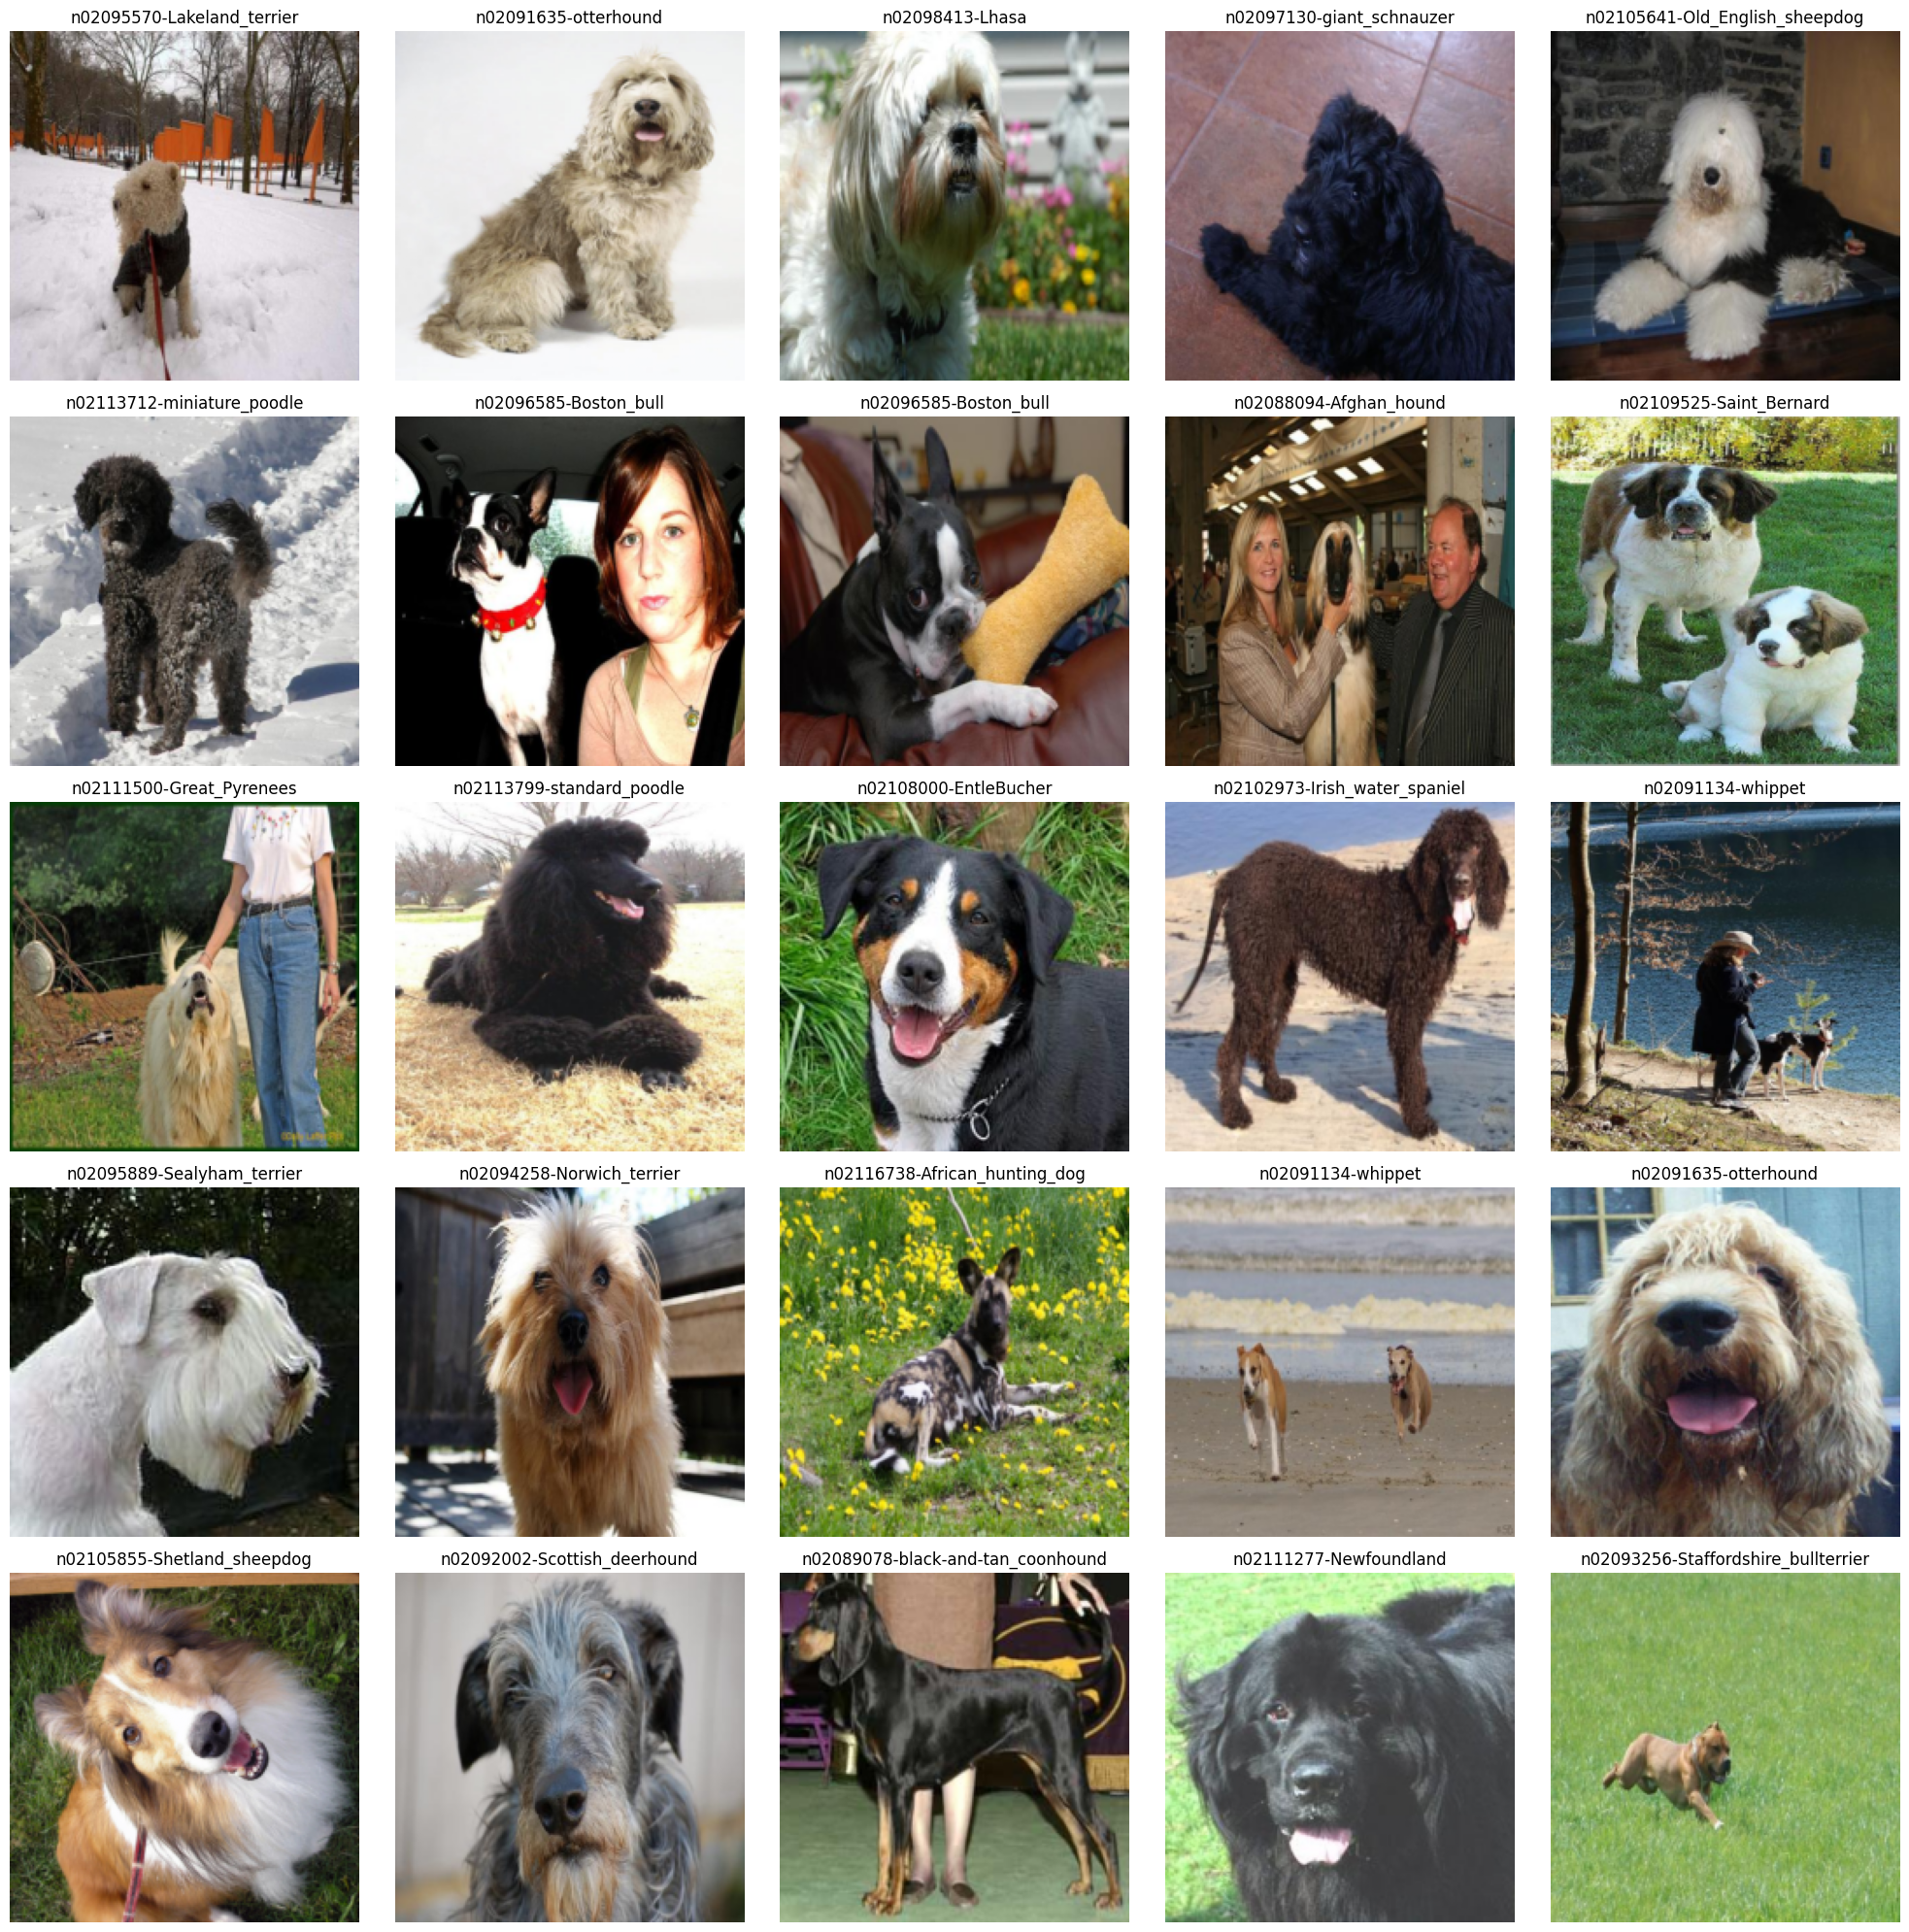

In [89]:
show_samples(X_full)

# 2 - Model Selection
Now that the basic dataset is ready, I can research a few pretrained models and decide on which one to use for our **Transfer Learning** task.